# NSMB Optimal Filter
### Multi-template OF Fit with One Time Shift Degree of Freedom Between Templates
-----
Bill Page 

Date: 190205

This fit is called the "NSMB Optimal Filter" because it fits amplitudes for:

* N signal templates that are allowed to time shift anywhere in the trace
* M background templates that are fixed in time.

This fit was first writted by Matt Pyle to subtract off effects of muons from test facility data. It has been resurrected for a different application: fitting background pileup events in the presence of laser-triggered events with known start times. This new application has required some tweaks to the fit. This notebook describes the general algorithm and the things I've added to it.

In [5]:
import numpy as np
import qetpy as qp
import matplotlib.pyplot as plt

Before getting into how this fit is performed, we motivate it with a few use cases:

### 1) Fitting out contamination from muons in surface test facility data:

The free parameters in the fit are:
* the amplitude of the pulse
* the time delay of the pulse
* the amplitude of the DC component
* the amplitude of the muon tail (slope) component

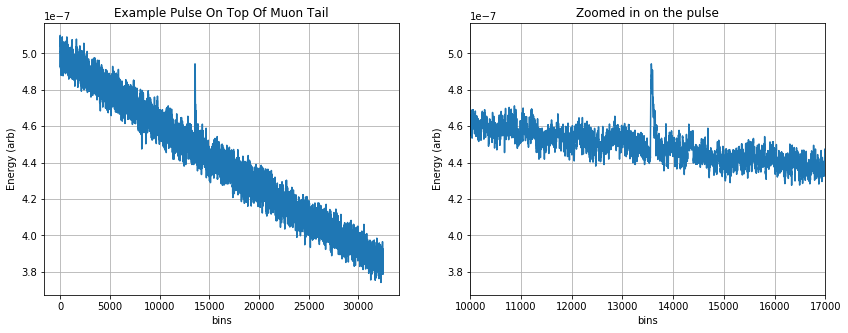

In [46]:
# create noise + fake pulse + muon tail, also outputting template for pulse and psd for noise
signal, template, psd = qp.sim._sim_nsmb.create_example_pulseplusmuontail()
signal = (-1)*signal # flip polarity for positive going pulse

plt.figure(figsize=(14,5));
plt.subplot(1,2,1)
plt.plot(signal, '-');
plt.xlabel('bins')
plt.ylabel('Energy (arb)')
plt.title('Example Pulse On Top Of Muon Tail')
plt.grid()
plt.subplot(1,2,2)
plt.plot(signal,'-')
plt.xlim([10000, 18000])
plt.xlabel('bins')
plt.ylabel('Energy (arb)')
plt.title('Zoomed in on the pulse')
plt.grid()

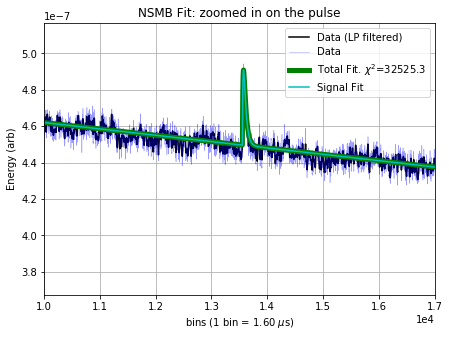

In [48]:
nbin = len(signal)

# construct the background templates which are just a slope and a baseline
backgroundtemplates, backgroundtemplatesshifts = qp.core._of_nsmb.get_slope_dc_template_nsmb(nbin)

# setup the NSMB
fs = 625e3 # example sample rate
(psddnu,phi,Pfs, P, sbtemplatef,
 sbtemplatet,iB,B,ns,nb,bitcomb,lfindex)  = qp.of_nsmb_setup(template,backgroundtemplates,psd, fs)

# invert the P matrix -- see below if interested in this
iP = qp.of_nsmb_getiP(P)    

# give bin window over which to look for signal
indwindow = np.arange(0,len(template))

# put the window into a list (can have multiple list elements)
indwindow_nsmb = [indwindow[:,None].T]

lgcplotnsmb = True
(amps_nsmb, t0_s_nsmb, chi2_nsmb,
chi2_nsmb_lf,resid) = qp.of_nsmb(signal,
                                phi, 
                                sbtemplatef.T, 
                                sbtemplatet, iP, 
                                psddnu.T, fs, 
                                indwindow_nsmb, ns, nb, 
                                bitcomb, lfindex, 
                                lgcplot=lgcplotnsmb,lgcsaveplots=False)
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.xlim([10000, 18000]);
plt.ylabel('Energy (arb)');
plt.title('NSMB Fit: zoomed in on the pulse');

By eye, the 4 free parameters (the amplitude of the pulse, the time delay of the pulse, the amplitude of the DC component, the amplitude of the slope component) have been fit well. One could imagine cutting on the amplitude of the pulse to obtain a better selection of noise, or subtracting the slope fit from the data to remove the contamination from muons, thereby recovering a noise trace that is a closer realization of the fundamental electronic noise.

On to the next use case:

### 2) Fitting pileup background events in the presence of laser-triggered events with known start times:

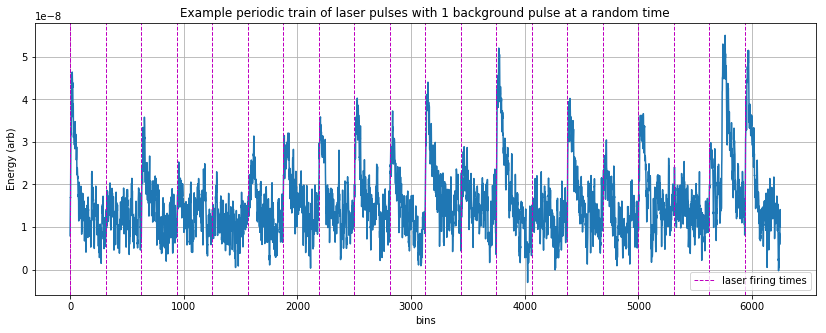

In [61]:
fs = 625e3
ttlrate = 2e3

# create noise + fake laser trigger pulses at certain start times + a background pulse at a random time
# also outputting template for the pulse shapes and psd for noise
signal, template, psd = qp.sim._sim_nsmb.create_example_ttl_leakage_pulses(fs,ttlrate)
signal = (-1)*signal # flip polarity for positive going pulse

nbin = len(signal)

# get templates for background, as well as
(backgroundtemplates,
backgroundtemplateshifts,
backgroundpolarityconstraint,
indwindow_nsmb) = qp.core._of_nsmb.maketemplate_ttlfit_nsmb(template, 
                                                              fs, 
                                                              ttlrate, 
                                                              lgcconstrainpolarity=True,
                                                              lgcpositivepolarity=True,
                                                              notch_window_size=1)

plt.figure(figsize=(14,5));
plt.plot(signal, '-');
plt.xlabel('bins')
plt.ylabel('Energy (arb)')
plt.title('Example periodic train of laser pulses with 1 background pulse at a random time')
plt.grid()
plt.axvline(x=backgroundtemplateshifts[0],linestyle='--', color='m',linewidth=1, label='laser firing times')
for ii in range(1, len(backgroundtemplateshifts)):
    plt.axvline(x=backgroundtemplateshifts[ii],linestyle='--', color='m',linewidth=1)
plt.legend();
                                


all good


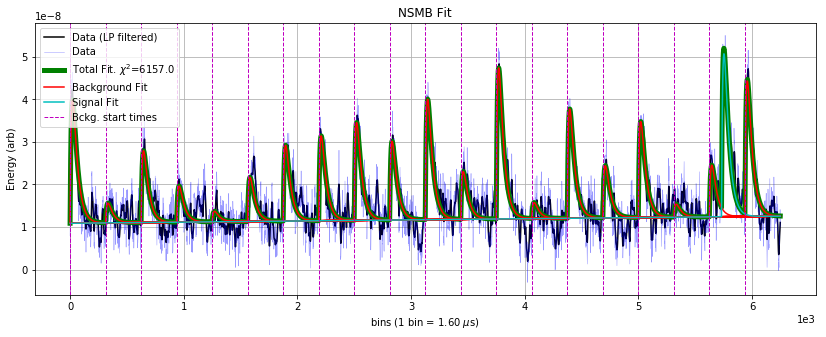

In [55]:
# concatenate signal and background template matrices and take FFT
sbtemplatef, sbtemplatet = qp.of_nsmb_ffttemplate(np.expand_dims(template,1), backgroundtemplates)

(psddnu, phi, Pfs, P,
sbtemplatef, sbtemplatet, iB,
B, ns, nb, bitcomb, lfindex)  = qp.of_nsmb_setup(template, backgroundtemplates, psd, fs)

sigpolarityconstraint = np.ones(1)


lgcplotnsmb = True

(amps_nsmb,t0_s_nsmb, 
 chi2_nsmb,chi2_nsmb_lf,
 resid,amps_sig_nsmb_cwindow,
 chi2_nsmb_cwindow,
 t0_s_nsmb_cwindow,
 amp_s_nsmb_int,
 t0_s_nsmb_int,
 chi2_nsmb_int,
 amps_sig_nsmb_cwindow_int,
 chi2_nsmb_cwindow_int,
 t0_s_nsmb_cwindow_int) = qp.of_nsmb_con(signal, phi, Pfs,
                                         P, sbtemplatef.T, sbtemplatet,
                                         psddnu.T, fs, indwindow_nsmb, ns,nb, bitcomb, lfindex,
                                         background_templates_shifts = backgroundtemplateshifts,
                                         bkgpolarityconstraint = backgroundpolarityconstraint,
                                         sigpolarityconstraint = sigpolarityconstraint,
                                         lgcplot=lgcplotnsmb,lgcsaveplots=False)

fig = plt.gcf()
fig.set_size_inches(14,5)
plt.ylabel('Energy (arb)');
plt.title('NSMB Fit');

There is a large background pileup pulse at bin ~ 5700, which is fit as the signal component because it occurs outside of the known times that the laser fires at the detector (given by the vertical lines). One might want to construct a discrimination parameter to determine, in a statistical sense, the likelihood that a background pileup pulse exists in the data.

To do this, we rerun the fit without the signal component and look at the $\Delta \chi^2$ between the two fits:

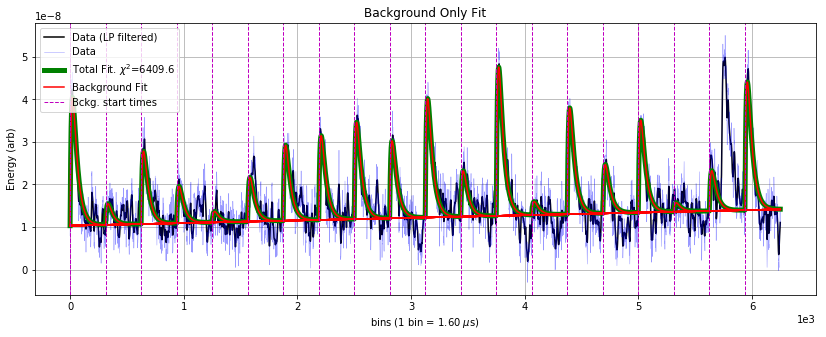

In [63]:
(ampsbonly_nsmb, chi2bonly_nsmb,
 chi2bonly_nsmb_lf) = qp.of_mb(signal, phi, sbtemplatef.T, sbtemplatet,
                                    iB, B, psddnu.T, fs, ns, nb, lfindex,
                                    background_templates_shifts = backgroundtemplateshifts,
                                    bkgpolarityconstraint = backgroundpolarityconstraint,
                                    sigpolarityconstraint = sigpolarityconstraint,
                                    lgcplot=True, lgcsaveplots=False)
fig = plt.gcf()
fig.set_size_inches(14,5)
plt.ylabel('Energy (arb)');
plt.title('Background Only Fit');

The difference in $\chi^2$ between the fits is 6409.6 - 6157 = 252.6. For noise to produce this $\Delta \chi^2$, it would be a $\sigma = \sqrt{\Delta \chi^2} \sim 16$ fluctuation --- so we can say with high confidnce there's background pileup here.

***

### Derivation


The $\chi^2$ for the fit is

\begin{equation}
\chi^2(\textbf{a}, t_0) = \sum_{k} \frac{|\tilde{S}_n - \sum_{n=1}^{N} a_n e^{-2\pi i t_0 f_k} \tilde{A}_{n,k} - \sum_{m=N}^{N+M}a_m \tilde{A}_{m,k}|^2}{J_k} 
\end{equation}

where we have defined

 * $t_{0}$: the time offset of the N signal templates
 * $J$: the noise PSD
 * $S$: the trace
 * $A$: the templates
 * $N/M$: the number of signal/background templates
 * $n/m$: the index over signal/background templates
 * $k$: the index over frequencies
       
       
We analytically solve for the $\chi^2$ minimum and speed up the calculation by using the inverse Fourier transform wherever possible.

Equation 1 hides some of the complexity of the calculation because both $\textbf{P}$ and $\textbf{q}$ depend on $t_0$, the time delay offset of the signal template. In the algorithm, the amplitudes are calculated for each time delay--$\textbf{a}(t_0)$--and for the global minimum we pick the time delay that gives the lowest $\chi^2$. This initially seems to be getting nasty computationally, where if your data has 4096 time bins you have to do 4096 matrix inversions, but we can speed up the calculation in a couple ways:

1. The $\textbf{P}$ matrix does not depend on the data $S$ and therefore it can be precomputed and inverted for every $t_0$ before looping over the traces
    * We will see below that to impose amplitude polarity constraints, we will not be able to precompute $\textbf{P}$ as it would require too much RAM, and so the algorithm is much slower if amplitude polarity constraints are turned on 
    2. The first row of $\textbf{q}$ and the first row and column of $\textbf{P}$, except for the (1,1) element, are inverse Fourier transforms. Using the same old trick that is used in the stanard optimal filter algorithm with a time delay, these elements can be computed quickly in $\mathcal{O}(n \text{log} n)$ time.

In the algorithm a few quantities are precomputed to speed up calculations. In the code, these quantities are named and defined as below:


 * $\textbf{PF}$, a 3 by 3 by k matrix

\begin{equation}
 \textbf{PF} = \left( \begin{array}{ccc}
\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{1,k}}{J_{k}} & \frac{\tilde{A}_{1,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \frac{\tilde{A}_{1,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \frac{\tilde{A}_{2,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \frac{\tilde{A}_{2,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{3,k}}{J_{k}} & \frac{\tilde{A}_{2,k}^{*}\tilde{A}_{3,k}}{J_{k}} & \frac{\tilde{A}_{3,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\end{array} \right) 
\end{equation}

 * $\textbf{PFS}$, a 3 by 3 matrix

\begin{equation}
 \textbf{PFS} = \left( \begin{array}{ccc}
\sum_{k}\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{1,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\sum_{k}\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{2,k}^{*}\tilde{A}_{2,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{2,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\sum_{k}\frac{\tilde{A}_{1,k}^{*}\tilde{A}_{3,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{2,k}^{*}\tilde{A}_{3,k}}{J_{k}} & \sum_{k}\frac{\tilde{A}_{3,k}^{*}\tilde{A}_{3,k}}{J_{k}} \\
\end{array} \right) 
\end{equation}

* $\phi$, a 3 by k matrix

\begin{equation}
 \phi = \left( \begin{array}{ccc}
\frac{\tilde{A}_{1,k}^{*}}{J_{k}} \\
\frac{\tilde{A}_{2,k}^{*}}{J_{k}} \\
\frac{\tilde{A}_{3,k}^{*}}{J_{k}} \\
\end{array} \right) 
\end{equation}